# Introduction and overview
This is the notebook for the modeling component of the final project. The notebook is organized as follows. We first perform some initial EDA as supplement to the early EDA notebook in order to gain better understanding of the dataset. Then, we dive into feature enegineering by processing datetime features and vectorizing text-based features. After feature engineering, we perform modeling for prediction in order to answer and understand following question.

1. How to efficiently develop an accurate predictor of the popularity of reviews? The popularity here is referred to as the case where a review receives more than zero vote(s). Furthermore, which features are important in contributing to the prediction.

2. How to efficiently develop an accurate predictor of the rating score of reviews? We investigate the problem in two folds. We first try full-category classification which means that the model aims for predicting the score ranging between 1 and 5 based on given features. By trying multiple methods, we conclude that the full-category classification problem is hard which might be the consequence of the imbalanced dataset. Then, we dive into a rather simple version -- binary classification problem, by aggregating all rating scores below five as "negative" and all rating scores equal to five as "positive". As the dataset is biased towards five-star rating, this aggregation bypasses the challenges in low-score categories. We perform modeling using logistic regression as a baseline from which we see that interactions among word features are important but not yet captured by logistic regression. To improve the performance of the modeling, we switch to a more complex nonlinear classifier -- random forest. We see that the nonlinearity and interaction brought by random forest significantly improves the accuracy of the result.

The next part in this notebook aims for understanding the hardness of the proposed classification problems and explore potential rooms for model compression by using dimensionality reduction. To understand the first question, we visualize the high dimensional feature space by a further projection onto a two dimensional manifold. We observe highly complex structure in the case of full-category classification. By switching to the binary classification problem, the issue is slightly remedied. The projected result also suggests the room of possible dimensionality reduction which could be used to both simplify the model and accelerate training and inference for large scale deployments. We then explore a stacking model built from PCA following a random forest classifier. By depicting the cross validation accuracy score, we observe that compressing the feature space dimension to 15% of its original one can still preserve the high accuracy in the model performance. 

The last part in this notebook is a demonstration of the recommendation system built from the dataset. We perform collaborative filtering to recommend similar products by prioritizing those whose correlation scores are high with the given product. Collaborative filtering constructs a hidden vector representation of each product by using singular value decomposition. Then, the correlation score is calculated by the cosine similarity between hidden vectors.

# Summary of related questions and their answers
- **Q1.** What are the research questions that you are answering through your analysis? What type of machine learning problem are you investigating?
- **A1.**  (1) Can we effificently model predictor of target variables based on the customers' reviews? The variables of our interest in this notebook are the boolean popularity score, indicating whether a review received more than zero vote(s), and the original or the aggregated rating score given by a reviewer. (2) What model may give the best accuracy to the customer rating prediction model? The details are unrolled in the previous section.

- **Q2.** Which model(s) do you use and why?
- **A2.** For each prediction target, we try both logistic regression (or its multi-class counterpart multinomial logistic regression) and nonlinear classifier -- random forest. The use of logistic regression is due to its structural simplicity, which has clear statistical meaning in its derived coefficients. Furthermore, as the simplest classifier, the performance of logistic regression also serves as the baseline of other methods. However, due to the nature of interaction between words, we must seek for better modeling accuracy by going beyond generalized linear models like logistic regression. For example, the word "star" in the review can either mean positive review when encountering with "five" or completely negative review with "one". One common practice is using nonlinear classifier like random forest to automatically introduce high order interactions. Our practice also suggests that the interaction is induced and the performance metrics are raised.

- **Q3.** How do you use your data for training and testing?
- **A3.** Before presenting the machine learning model, we split the dataset randomly into a 70% training dataset and a 30% testing dataset. We train our models with respect to the training set and evaluate their performances on testing set. In the analyais of model compression, we perform cross validation in which a collection of randomly splitted folds of the dataset is derived for k-fold cross validation. This would reduce the influence of the choice of testing set.

- **Q4.** Does your model require hyperparameter tuning? If so, how do you approach it?
- **A4.** The hyperparameter tuning is studied in two scenarios. (1) The penalty type and strength in logistic regression. The intuition is that simply enforcing regularization in logistic regression might not be helpful because the regularization may isolate or emphasize a subset of features and the bottleneck due to the missing interaction is still unsolved. Hence, in order to better visualize this idea, we plot the curve of training and testing error  as a function of the inverse regularization strength and argue that the regularization should be set to None. (2) The compressed feature space to accelerate model training and inference but still maintain a high performance score. In this part, we use a stacking model built by PCA following a random forest classifier. To better showcase the performance of the model under certain choice of hyperparameters, we compute the accuracy of modeling by k-fold cross validation. Then, we conclude that compressing the feature space to 15% of its original dimension is sufficient to maintain accuracy metric almost identical to the full model.

- **Q5.** How do you engineer the features for your model? What are the rationales behind selecting these features?
- **A5.** We explore datetime features, vectorized text features and some aggregated features like sentimental scores. The reason for including datetime features is based on the sense that in some busy business months or days, more purchases may be conducted and the quality of the product would be harder to be controlled. The inclusion of vectorized text features is because language features are strong components in predicting relevant outcomes. The use of sentimental scores is due to the fact that the text vectorization may yield an extremely high dimensional feature space. Hence, aggregating these high dimensional features into a scalar feature variable would prevent overfitting.

- **Q6.** How do you perform cross-validation on your model?
- **A6.** See Q4 for discussion.

- **Q7.** What loss metrics are you using to evaluate your model? Why?
- **A7.** We use multiple choices of performance metrics in modeling, including RMSE, Log loss, and accuracy. RMSE is good in its intuitive and simple meaning which measures the average entry-wise deviation. Log loss is consistent with the training objective in logistic regression. However, the meaning of its value does not have clear indication. Accuracy improves that case by being compatible with classification problems but showcasing simple meaning.

- **Q8.** From a bias-variance tradeoff standpoint, how do you assess the performance of your model? How do you check if it is overfitting?
- **A8.** From a bias-variance tradeoff standpoint, the indication of overfitting is a good training performance but a poor testing performance, and the opposite one for underfitting. To gain intuition of whether our model is overfitting or not, we visualize the training and testing error in our analysis. Furthermore, we also present the dimension of the feature space to prevent the case that there are more features than the data size. Meanwhile, for complex models, we also employ cross validation to evaluate the model performance.

- **Q9.** How would you improve your model based on the outcome?
- **A9.** We first tune the model hyperparameters to improve the model performance. Furthermore, based on the intuition and numerical observation in terms of the feature interactions (see Q2), we employ nonlinear classifiers to include high order interaction among features. We also explore the room of model compression which is discussed in details in Q4.

- **Q10.** Are there any further extensions to your model that would be worth exploring?
- **A10.** Our analysis shows that the dataset is highly imbalanced. The lack in the structure exploring in projection-based visualization also indicates that the dataset might need further preprocessing to improve model performance. Some potential techniques include downsampling and recalibration of the original dataset to balance the dataset, and data augmentation by artificially generated data. These are future directions of this research.

# Preparation and feature engineering
After shortlisting and transforming promising variables (i.e., unixReviewTime, summaries text and reviewText), we conducted further feature engineering into promising features within those variables and investigated into its dimensions. First, we engineered a feature called "vec\_summary", which detects the appearance of certain words in summary text and saw that it has 1091 features that can capture the qualitative aspects of texts. Next, we utilized datetime\_feats (datetime transformation of unixReviewTime), to create a total of 19 booleans (i.e., 7 days, 12 months) features that show the days and months of the reviews in order to provide insight into temporal data and reveal seasonal trends in review. Subsequently, we created a feature capturing sentiment score of summary text by using the VADER lexicon. Similarly, another feature was crafted to assess the sentiment score from “reviewText”, also using VADER.
## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
plt.rcParams.update({'font.size': 15})

import warnings
warnings.filterwarnings("ignore")

## Load dataset and some additional EDA
More EDA can be found in the notebook titled "eda.ipynb". We present EDAs that are more relevant to the modeling in this notebook for simplicity.

In [2]:
df = pd.read_json("data/All_Beauty_5.json.gz", lines = True)
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN


### Columns with missing entries and their density

In [3]:
pd.concat([
    (df.isnull().sum() / len(df) * 100).rename("density (%)"),
    df.isnull().any().rename("has null"),
    df.dtypes.rename("dtype")
], axis = 1)

,density (%),has null,dtype
overall,0.000000,False,int64
verified,0.000000,False,bool
reviewTime,0.000000,False,object
reviewerID,0.000000,False,object
asin,0.000000,False,object
style,12.241412,True,object
reviewerName,0.000000,False,object
reviewText,0.094895,True,object
summary,0.094895,True,object
unixReviewTime,0.000000,False,int64


### (1) Drop rows without review nor summary (2) process vote and change null value in vote to 0

In [4]:
df = df[
    (~df["summary"].isnull()) & (~df["reviewText"].isnull())
]
df["vote"] = (
    df["vote"].fillna("0")
    .str.replace(",", "")
    .astype(int)
)
pd.concat([
    (df.isnull().sum() / len(df) * 100).rename("density (%)"),
    df.isnull().any().rename("has null"),
    df.dtypes.rename("dtype")
], axis = 1)

,density (%),has null,dtype
overall,0.000000,False,int64
verified,0.000000,False,bool
reviewTime,0.000000,False,object
reviewerID,0.000000,False,object
asin,0.000000,False,object
style,12.264689,True,object
reviewerName,0.000000,False,object
reviewText,0.000000,False,object
summary,0.000000,False,object
unixReviewTime,0.000000,False,int64


### Explore style features. 

In [5]:
styles = df["style"].apply(pd.Series).rename(columns = lambda s: re.findall(r"([^:]+):?$", str(s))[0])
dropped_columns = [col for col in styles.columns if styles[col].isnull().all()]
styles = styles.drop(columns = dropped_columns)
print("Dropped columns (all null):", dropped_columns)
styles.head()

Dropped columns (all null): ['0']


,Color,Design,Flavor,Scent Name,Size,Style Name
0,NaN,NaN,Classic Ice Blue,NaN,7.0 oz,NaN
1,NaN,NaN,Classic Ice Blue,NaN,7.0 oz,NaN
2,NaN,NaN,Classic Ice Blue,NaN,7.0 oz,NaN
3,NaN,NaN,Classic Ice Blue,NaN,7.0 oz,NaN
4,NaN,NaN,NaN,NaN,200ml/6.7oz,NaN


We find they are too sparse and hence exclude them without loss of generality.

In [6]:
densities = []
for feat in styles.columns:
    densities.append([
        styles[feat].notnull().sum() / len(styles) * 100,
        len(styles[feat].unique())
    ])
pd.DataFrame(
    densities,
    index = styles.columns,
    columns = ["non-null ratio (%)", "unique count"]
)

,non-null ratio (%),unique count
Color,7.187678,77
Design,0.399315,22
Flavor,0.228180,5
Scent Name,0.190150,9
Size,82.677315,290
Style Name,0.760601,5


The feature titled "Size" does not have many missing values. However, from the following visualization, we see that the use of this feature is challenging as either qualitative description is given or the unit is missing.

In [7]:
styles["Size"].value_counts().head(20)

 Small          202
 1              115
 250 Gram        94
 281             65
 150 Gram        62
 Shampoo         51
 5               50
 3               50
 6               50
 10              48
 7 Ounce         48
 8               45
 Multiset        44
 8.5oz           43
 4               40
 7               40
 17              36
 200ml/6.7oz     33
 7.6oz           32
 22              32
Name: Size, dtype: int64

## Add datetime features
We utilized datetime_feats (datetime transformation of unixReviewTime), to create a total of 19 booleans (i.e., 7 days, 12 months) features that show the days and months of the reviews in order to provide insight into temporal data and reveal seasonal trends in review.

In [8]:
df["unixReviewTime"] = pd.to_datetime(df["unixReviewTime"], unit = "s")
datetime_feats = []

In [9]:
!pip install holidays

You should consider upgrading via the '/Users/dongyl/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [10]:
from datetime import date
import holidays

In [11]:
us_holidays = holidays.US()
df["holiday"] = df["unixReviewTime"].dt.date.isin(us_holidays)
print(
    "any review was written on holiday? ",
    df["holiday"].any()
)
print("this feature is useless as all in on non-holiday")

any review was written on holiday?  False
this feature is useless as all in on non-holiday


In [12]:
# month name
df["month"] = df["unixReviewTime"].dt.strftime("%B")
df["month"].value_counts()

August       598
September    550
April        548
March        518
July         464
May          445
February     413
January      405
December     352
November     338
October      320
June         308
Name: month, dtype: int64

In [13]:
dummies = pd.get_dummies(df["month"], prefix = "month")
df = df.merge(dummies, left_index = True, right_index = True)
datetime_feats += dummies.columns.tolist()

In [14]:
# weekday
df["weekday"] = df["unixReviewTime"].dt.strftime("%A")
df["weekday"].value_counts()

Monday       891
Tuesday      819
Thursday     809
Saturday     717
Friday       715
Sunday       659
Wednesday    649
Name: weekday, dtype: int64

In [15]:
dummies = pd.get_dummies(df["weekday"], prefix = "weekday")
df = df.merge(dummies, left_index = True, right_index = True)
datetime_feats += dummies.columns.tolist()

We show that all time record of the review data is set to late night which migh tbe the consequence of some system setting. Hence, the exploration of hour-based feature does not make sense.

In [16]:
# part of the day
# The system does not record the hour of review, ignore this feature
bins = [0, 4, 8, 12, 16, 20, 24]
labels = ["Late Night", "Early Morning", "Morning", "Noon", "Eve", "Night"]
df["PofD"] = pd.cut(df["unixReviewTime"].dt.hour, bins = bins, labels = labels, include_lowest = True)
df["PofD"].value_counts()

Late Night       5259
Early Morning       0
Morning             0
Noon                0
Eve                 0
Night               0
Name: PofD, dtype: int64

## Preparing aggregated binary variables.
There are two binary variables: the popularity score, namely whether a review received more than zero vote(s), and the rating positivity, i.e., whether a review gives five star.

From the following part, we could see that the unaggregated data is highly imbalanced. Aggregation could relax the imbalance in the dataset.

0       4707
2        238
3         95
4         46
5         28
15        20
6         18
19        17
16        14
12        14
9          9
14         7
30         7
8          7
20         5
18         5
22         4
17         4
28         4
25         2
1341       2
7          2
48         2
13         1
186        1
Name: vote, dtype: int64

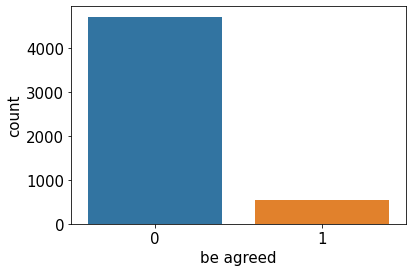

In [17]:
df["be agreed"] = (df["vote"] > 0).astype(int)
sns.countplot(df["be agreed"])
df["vote"].value_counts()

5    4639
4     332
1     115
3     109
2      64
Name: overall, dtype: int64

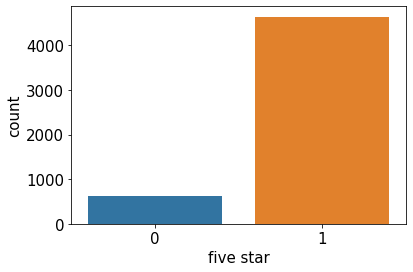

In [18]:
df["five star"] = (df["overall"] == 5).astype(int)
sns.countplot(df["five star"])
df["overall"].value_counts()

<AxesSubplot:xlabel='overall', ylabel='count'>

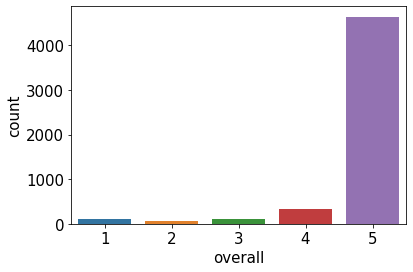

In [19]:
sns.countplot(df["overall"])

## Clean up text-based columns -- review text and summary
The preprocessing includes lowerizing and stemming. This standardization cleans up the text and removes redundancy in vectorization.

In [20]:
!pip install nltk

You should consider upgrading via the '/Users/dongyl/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [21]:
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

stemmer = PorterStemmer()
stop_words = stopwords.words("english")
sent = SentimentIntensityAnalyzer()

def text_cleaning(x: str) ->  str:
    # lowerize words
    corp = str(x).lower()
    # remove chars that are not literal
    corp = re.sub("[^a-zA-Z]+", " ", corp).strip()
    # tokenize words
    tokens = word_tokenize(corp)
    # remove stop words
    return " ".join([t for t in tokens if t not in stop_words])

def text_sentiment_score(x: str) -> float:
    return sent.polarity_scores(x)["compound"]
    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dongyl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
for s in ["reviewText", "summary"]:
    df["cleaned " + s] = df[s].str.lower().apply(text_cleaning)
    df["sentiment score " + s] = df[s].apply(text_sentiment_score)
# apply processing for both review text and summary, and preview the change
df[["cleaned summary", "summary", "sentiment score summary"]].head()

,cleaned summary,summary,sentiment score summary
0,five stars,Five Stars,0.0000
1,good face,Good for the face,0.4404
2,smells awful,Smells awful,-0.4588
3,truth nothing like aqua velva man,Truth is There IS Nothing Like an AQUA VELVA MAN.,0.0490
4,bvlgari shampoo,Bvlgari Shampoo,0.0000


## Vectorize texts
The text will be featurized via term frequency inverse document frequency (TF-IDF) vectorization. It prioritizes the frequency of words' apperance within a single review but penalizes the frequency of cross review apperance. The reason for this construction can be intuitively understood by taking the word "is" as an example. Though "is" is frequent in each review, it does not contain useful meaning as different reviews may all have it. However, some words like "milky" stands for the product detail for a product. It could be frequent in the review of shampoo but it won't be frequent everywhere so the penalization is weak.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
# initialization
vectorizer_summary = TfidfVectorizer(stop_words = "english")
# fit a TF-IDF vectorizer and transform the text data
vec_summary_crsmat = vectorizer_summary.fit_transform(df["cleaned summary"])
vec_summary = pd.DataFrame(
    vec_summary_crsmat.toarray(), columns = vectorizer_summary.get_feature_names_out(), index = df.index
)
print(vec_summary.shape)

# vectorized reviewText has too many features, ignore it in modeling to avoid overfitting
vectorizer_reviewText = TfidfVectorizer(stop_words = "english")
vec_reviewText_crsmat = vectorizer_reviewText.fit_transform(df["cleaned reviewText"])
vec_reviewText = pd.DataFrame(
    vec_reviewText_crsmat.toarray(), columns = vectorizer_reviewText.get_feature_names_out(), index = df.index
)
print(vec_reviewText.shape)

(5259, 1091)
(5259, 5381)


# Modeling 

In [25]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

## Train test splitting
After cleaning the dataset and exploring potential features, we proceeded to design and explore potential rating-predictor models. We split the dataset to randomly reserve 30% of data as testing data and the other 70% as training data in order to gauge the algorithmic performance. We prepared feature matrices (E.g., X_train and X_test) for training and testing data, as well as target matrices Y_train and Y_test. 

In [26]:
test_frac = 0.3
test_set = df.sample(frac = test_frac, replace = False, random_state = 42)
test_indices = test_set.index
train_set = df.loc[~df.index.isin(test_indices)]
train_indices = train_set.index
vec_summary_test = vec_summary.loc[test_indices]
vec_summary_train = vec_summary.loc[train_indices]

feats = datetime_feats + ["sentiment score summary", "sentiment score reviewText"]

X_train = vec_summary_train.merge(train_set[feats], left_index = True, right_index = True)
X_test = vec_summary_test.merge(test_set[feats], left_index = True, right_index = True)

Standarize the data for numerical stability.

In [27]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)

After making the training and test dataset, we proceeded to investigate into different potential models that can be used as our rating-predictor and compare the model performance against quality checkpoint (e.g., ROC, confusion matrix, RMSE, etc) to investigate the optimal model to be used for our predictor. As a classification problem, the simplest method is logistic regression and its multi-class counterpart. Logistic regression enjoys the simple structure of the model as a generalized linear model. Furthermore, it conveys clearer statistical meaning of each feature compared with how a complex nonlinear classifier does. However, the simple structure of the model puts the risk of intrinsic modeling bias to the feature engineering based on extensive domain knowledge of the researchers. Usually, nonlinear models like random forest and neural networks could outperform logistic regression by including more hidden machine-learning features. These features are usually referred to as the higher order interactions in the machine learning community. To see the importance of each feature, for each model designed, we visualize the top 30 features that contribute to the classifiers’ predicted outcomes, and their weights in the classifier to identify the most influential factors contributing to the model’s decision-making process. This provides insights into which variables held the most predictive power, and also motivates us to study the reduction of model complexity by stacking a dimensionality reduction subroutine before applying the classifier. Meanwhile, we also performe a K-Means clustering on the vectorized review summary. By presenting the top 10 most weighted word in each cluster, we also observe great similarity among clusters. This also motivates the potential room of model complexity reduction.

## Predicting the popularity of review
The visualization of the labels in training and testing dataset confirm that they are consistently imbalanced.

Text(0.5, 0.98, 'Category distribution on training and testing dataset')

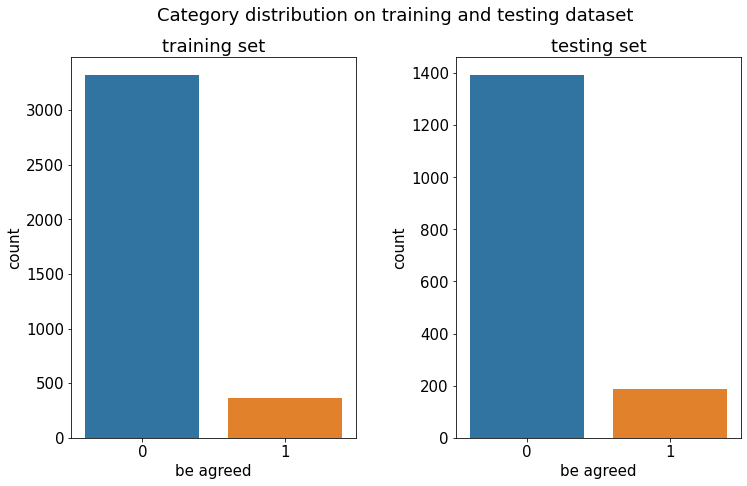

In [28]:
Y_train = train_set["be agreed"]
Y_test = test_set["be agreed"]

fig, axes = plt.subplots(1, 2, figsize = (12, 7))
plt.subplots_adjust(wspace = 0.35)
sns.countplot(Y_train, ax = axes[0])
axes[0].set_title("training set")
sns.countplot(Y_test, ax = axes[1])
axes[1].set_title("testing set")
plt.suptitle("Category distribution on training and testing dataset")

### Logistic regression for predicting popularity
investigate training and testing errors

In [29]:
logit = LogisticRegression(random_state = 42)

logit.fit(X_train, Y_train)
pred = logit.predict(X_train)
print(
    "training error: RMSE", np.sqrt(mean_squared_error(pred, Y_train)), "Log loss", log_loss(pred, Y_train)
)
confusion_matrix(Y_train, pred)

training error: RMSE 0.18720263025896863 Log loss 1.2631435173040242


array([[3292,   24],
       [ 105,  260]])

In [30]:
pred = logit.predict(X_test)
print(
    "testing error: RMSE", np.sqrt(mean_squared_error(pred, Y_test)), "Log loss", log_loss(pred, Y_test)
)
confusion_matrix(Y_test, pred)

testing error: RMSE 0.24014148765631815 Log loss 2.0785630281430048


array([[1377,   14],
       [  77,  110]])

<Figure size 1080x1080 with 0 Axes>

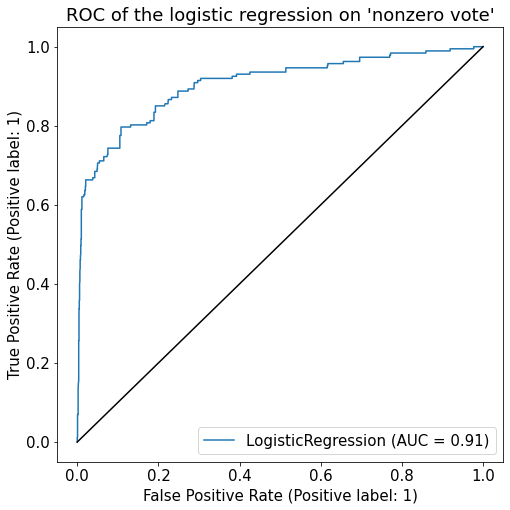

In [31]:
# ROC curve
plt.figure(figsize = (15, 15))
roc = metrics.RocCurveDisplay.from_estimator(logit, X_test, Y_test)
roc.figure_.set_figwidth(8)
roc.figure_.set_figheight(8)
plt.plot([0, 1], [0, 1], "-", c = "black")
plt.title("ROC of the logistic regression on 'nonzero vote'")
plt.legend(loc = "lower right", prop={'size': 15})
plt.show()

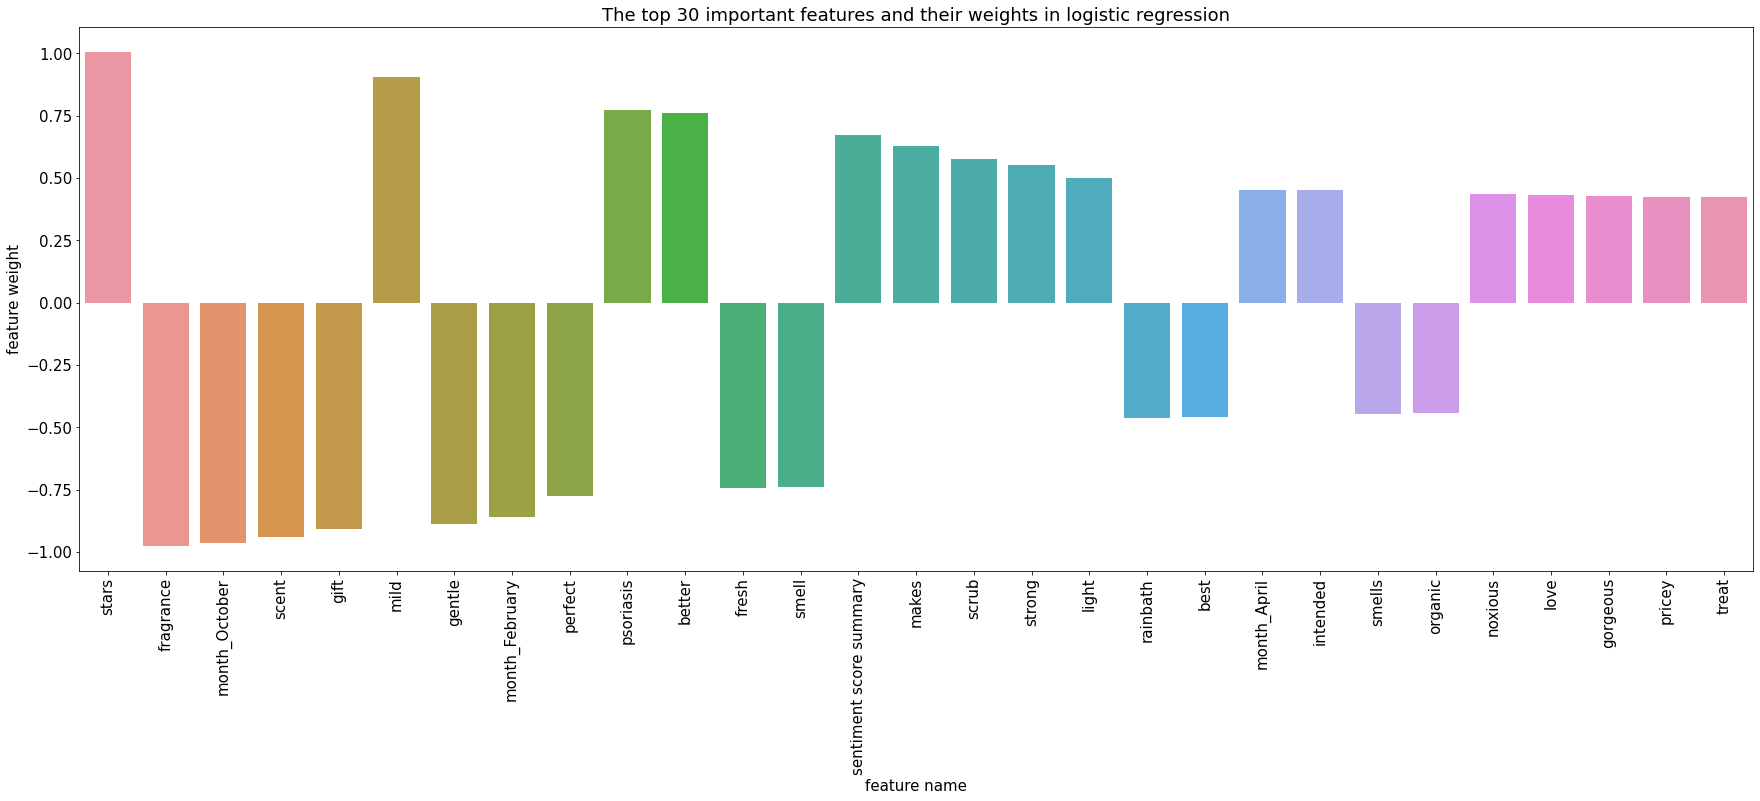

In [32]:
# visualize the top 30 important features in the logistic regression model
num_important_feats = 30
feat_indices = np.abs(logit.coef_.flatten()).argsort()[-1:-num_important_feats:-1]
important_feat_names = X_train.columns[feat_indices]
important_feat_weights = logit.coef_.flatten()[feat_indices]
important_feats = pd.DataFrame({"feature name": important_feat_names, "feature weight": important_feat_weights})
logit_feat_indices = feat_indices
logit_feat_names = important_feat_names
plt.figure(figsize = (30, 10))
sns.barplot(data = important_feats, x = "feature name", y = "feature weight")
plt.title(f"The top {num_important_feats} important features and their weights in logistic regression")
plt.xticks(rotation=90)
plt.show()

### Random forest classifier, nonlinear classification for predicting popularity

In [33]:
rfclf = RandomForestClassifier(random_state = 42)

rfclf.fit(X_train, Y_train)
pred = rfclf.predict(X_train)

print(
    "training error: RMSE", np.sqrt(mean_squared_error(pred, Y_train)), "Log loss", log_loss(pred, Y_train)
)

pred_test = rfclf.predict(X_test)

print(
    "testing error: RMSE", np.sqrt(mean_squared_error(pred_test, Y_test)), "Log loss", log_loss(pred_test, Y_test)
)

confusion_matrix(Y_train, pred)

training error: RMSE 0.10424304453346035 Log loss 0.39167240846636414
testing error: RMSE 0.17073612338234084 Log loss 1.0507021900503102


array([[3290,   26],
       [  14,  351]])

ROC curve and AUC are drastically improved.

<Figure size 1080x1080 with 0 Axes>

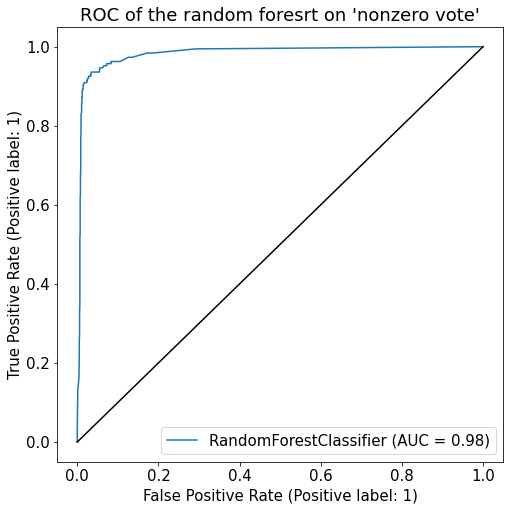

In [34]:
plt.figure(figsize = (15, 15))
roc = metrics.RocCurveDisplay.from_estimator(rfclf, X_test, Y_test)
roc.figure_.set_figwidth(8)
roc.figure_.set_figheight(8)
plt.plot([0, 1], [0, 1], "-", c = "black")
plt.title("ROC of the random foresrt on 'nonzero vote'")
plt.legend(loc = "lower right", prop={'size': 15})
plt.show()

In random forest, the weight of feature is unsigned. So, the statistical meaning of the diagram is just the importance of each weight in making decision.

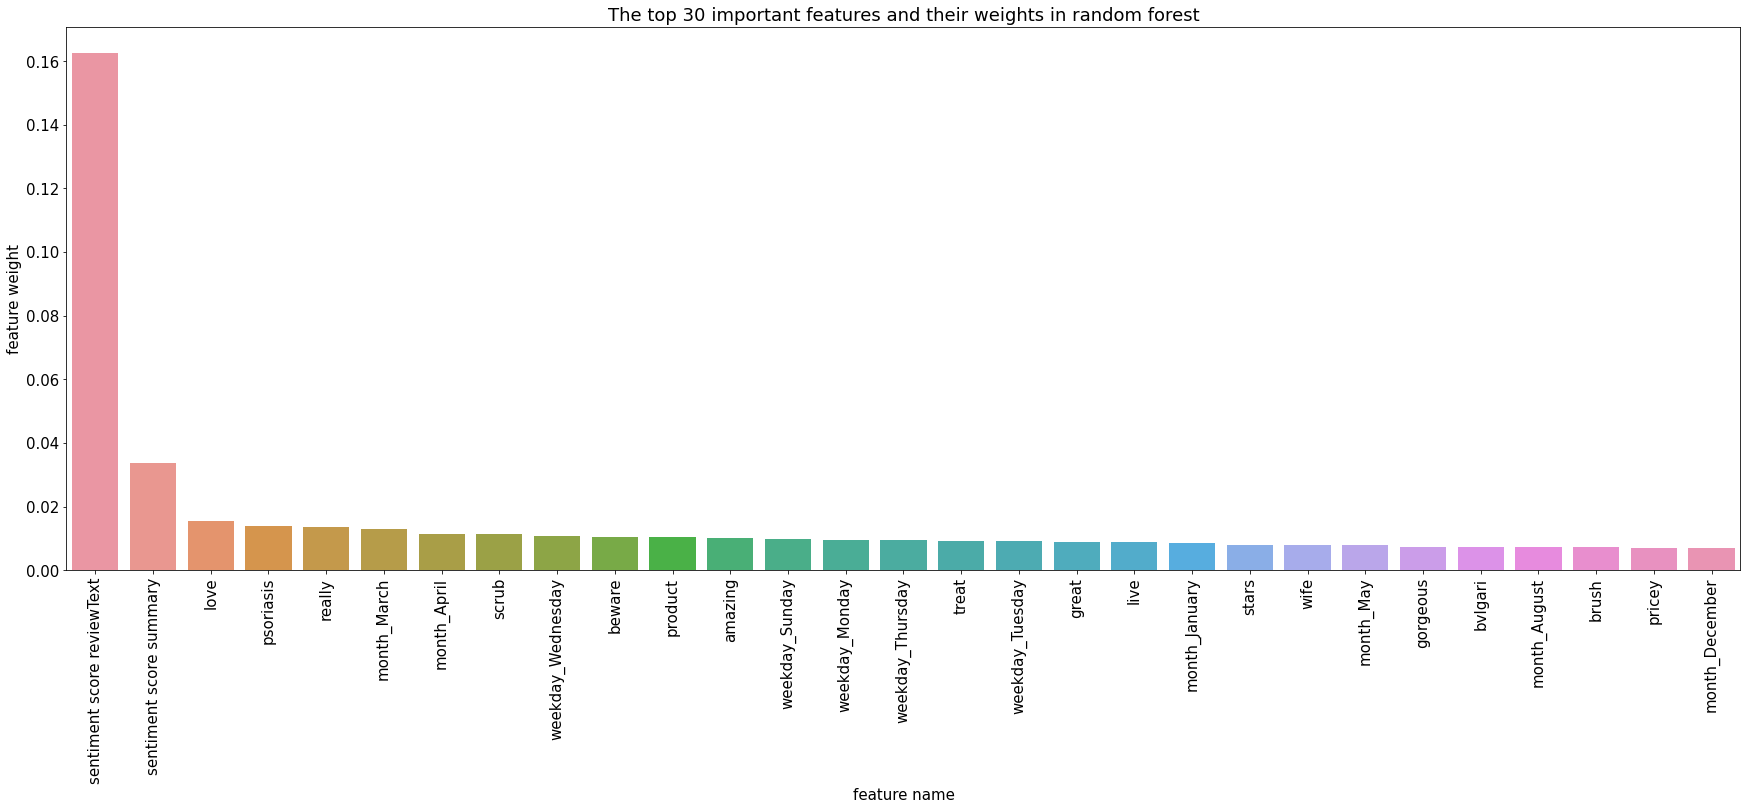

In [35]:
num_important_feats = 30
feat_indices = np.abs(rfclf.feature_importances_).argsort()[-1:-num_important_feats:-1]
important_feat_names = X_train.columns[feat_indices]
important_feat_weights = rfclf.feature_importances_[feat_indices]
important_feats = pd.DataFrame({"feature name": important_feat_names, "feature weight": important_feat_weights})
plt.figure(figsize = (30, 10))
sns.barplot(data = important_feats, x = "feature name", y = "feature weight")
plt.title(f"The top {num_important_feats} important features and their weights in random forest")
plt.xticks(rotation=90)
plt.show()

## Predicting positivity of review, namely five-star
visualize the consistency and imbalance in training and testing dataset

Text(0.5, 0.98, 'Category distribution on training and testing dataset')

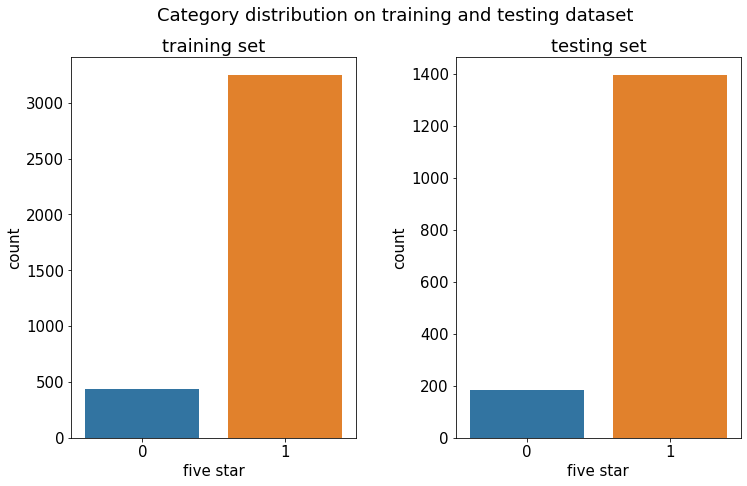

In [36]:
Y_train = train_set["five star"]
Y_test = test_set["five star"]

fig, axes = plt.subplots(1, 2, figsize = (12, 7))
plt.subplots_adjust(wspace = 0.35)
sns.countplot(Y_train, ax = axes[0])
axes[0].set_title("training set")
sns.countplot(Y_test, ax = axes[1])
axes[1].set_title("testing set")
plt.suptitle("Category distribution on training and testing dataset")

### Logistic regression for predicting positivity

In [37]:
logit = LogisticRegression(random_state = 42)

logit.fit(X_train, Y_train)
pred = logit.predict(X_train)
print(
    "training error: RMSE", np.sqrt(mean_squared_error(pred, Y_train)), "Log loss", log_loss(pred, Y_train)
)
confusion_matrix(Y_train, pred)

training error: RMSE 0.125525247993092 Log loss 0.5679249922762281


array([[ 383,   53],
       [   5, 3240]])

In [38]:
pred = logit.predict(X_test)
print(
    "testing error: RMSE", np.sqrt(mean_squared_error(pred, Y_test)), "Log loss", log_loss(pred, Y_test)
)
confusion_matrix(Y_test, pred)

testing error: RMSE 0.22374845553913222 Log loss 1.8044668046516192


array([[ 112,   72],
       [   7, 1387]])

ROC curve and AUC suggests that predicting positivity is harder than predicting popularity.

Text(0.5, 1.0, "ROC of the logistic regression on 'five star'")

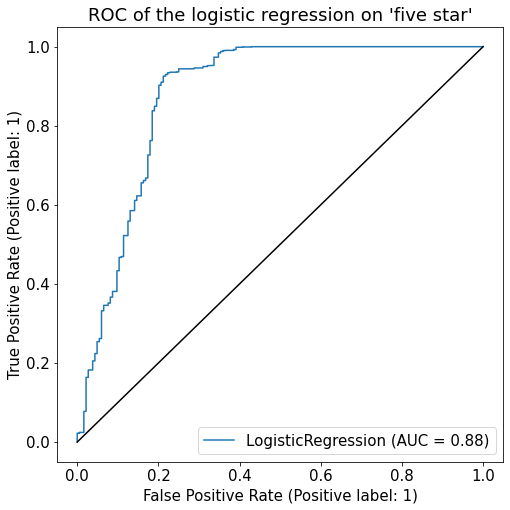

In [39]:
roc = metrics.RocCurveDisplay.from_estimator(logit, X_test, Y_test)
roc.figure_.set_figwidth(8)
roc.figure_.set_figheight(8)
plt.plot([0, 1], [0, 1], "-", c = "black")
plt.title("ROC of the logistic regression on 'five star'")

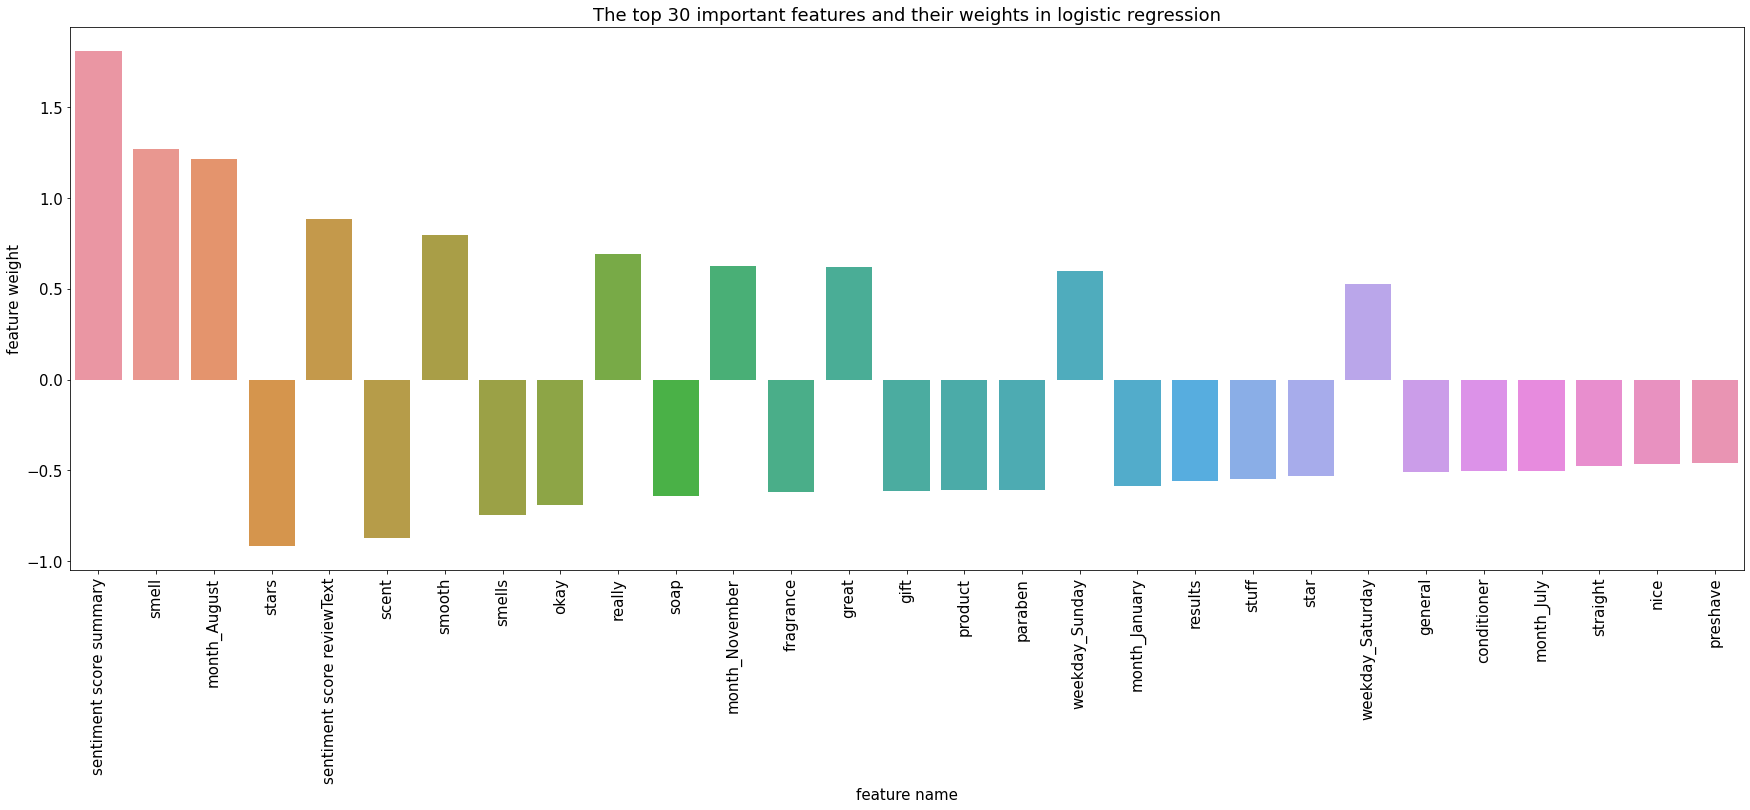

In [40]:
num_important_feats = 30
feat_indices = np.abs(logit.coef_.flatten()).argsort()[-1:-num_important_feats:-1]
important_feat_names = X_train.columns[feat_indices]
important_feat_weights = logit.coef_.flatten()[feat_indices]
important_feats = pd.DataFrame({"feature name": important_feat_names, "feature weight": important_feat_weights})
logit_feat_indices = feat_indices
logit_feat_names = important_feat_names
plt.figure(figsize = (30, 10))
sns.barplot(data = important_feats, x = "feature name", y = "feature weight")
plt.title(f"The top {num_important_feats} important features and their weights in logistic regression")
plt.xticks(rotation=90)
plt.show()

#### Random forest classifier, nonlinear classification for predicting positivity

In [41]:
rfclf = RandomForestClassifier(random_state = 42)

rfclf.fit(X_train, Y_train)
pred = rfclf.predict(X_train)

print(
    "training error: RMSE", np.sqrt(mean_squared_error(pred, Y_train)), "Log loss", log_loss(pred, Y_train)
)

pred_test = rfclf.predict(X_test)

print(
    "testing error: RMSE", np.sqrt(mean_squared_error(pred_test, Y_test)), "Log loss", log_loss(pred_test, Y_test)
)

confusion_matrix(Y_train, pred)

training error: RMSE 0.04037315754360501 Log loss 0.05875086126995482
testing error: RMSE 0.1725819729551732 Log loss 1.0735435420079253


array([[ 430,    6],
       [   0, 3245]])

ROC curve and AUC are drastically improved.

<Figure size 1080x1080 with 0 Axes>

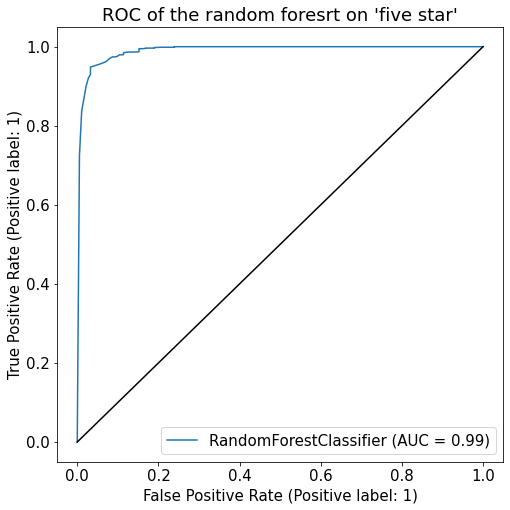

In [42]:
plt.figure(figsize = (15, 15))
roc = metrics.RocCurveDisplay.from_estimator(rfclf, X_test, Y_test)
roc.figure_.set_figwidth(8)
roc.figure_.set_figheight(8)
plt.plot([0, 1], [0, 1], "-", c = "black")
plt.title("ROC of the random foresrt on 'five star'")
plt.legend(loc = "lower right", prop={'size': 15})
plt.show()

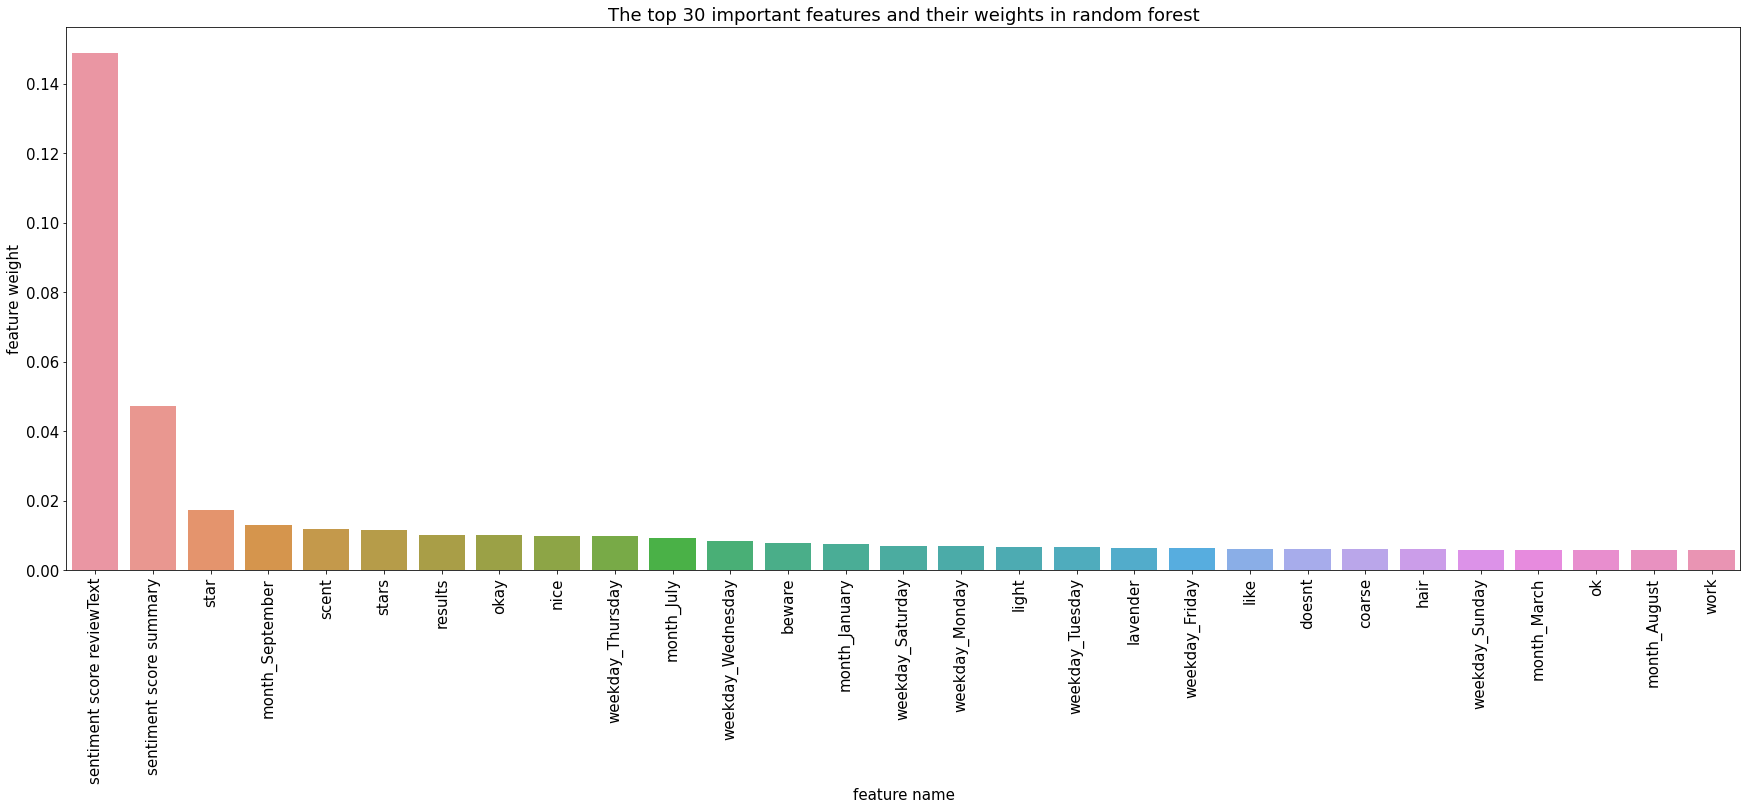

In [43]:
num_important_feats = 30
feat_indices = np.abs(rfclf.feature_importances_).argsort()[-1:-num_important_feats:-1]
important_feat_names = X_train.columns[feat_indices]
important_feat_weights = rfclf.feature_importances_[feat_indices]
important_feats = pd.DataFrame({"feature name": important_feat_names, "feature weight": important_feat_weights})
plt.figure(figsize = (30, 10))
sns.barplot(data = important_feats, x = "feature name", y = "feature weight")
plt.title(f"The top {num_important_feats} important features and their weights in random forest")
plt.xticks(rotation=90)
plt.show()

## Investigate the effect of regularization

In [44]:
# values of inverse penalty strength
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

# Initialize lists to store results for different models
# [i, 0, :] = l1, [i, 1, :] = l2
# i = 0 training, i = 1 testing
rmses = np.zeros((2, 2, len(C_values)), dtype = float)

# Logistic Regression without regularization
logit_none = LogisticRegression(penalty=None, random_state=42)
logit_none.fit(X_train, Y_train)
pred = logit_none.predict(X_train)
rmse_none = [0, 0]
rmse_none[0] = np.sqrt(mean_squared_error(pred, Y_train))
pred = logit_none.predict(X_test)
rmse_none[1] = np.sqrt(mean_squared_error(pred, Y_test))

# Logistic Regression with regularization
for i, C in enumerate(C_values):
    logit_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=C, random_state=42)
    logit_l1.fit(X_train, Y_train)
    pred = logit_l1.predict(X_train)
    rmses[0, 0, i] = np.sqrt(mean_squared_error(pred, Y_train))
    pred = logit_l1.predict(X_test)
    rmses[1, 0, i] = np.sqrt(mean_squared_error(pred, Y_test))

    logit_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=C, random_state=42)
    logit_l2.fit(X_train, Y_train)
    pred = logit_l2.predict(X_train)
    rmses[0, 1, i] = np.sqrt(mean_squared_error(pred, Y_train))
    pred = logit_l2.predict(X_test)
    rmses[1, 1, i] = np.sqrt(mean_squared_error(pred, Y_test))

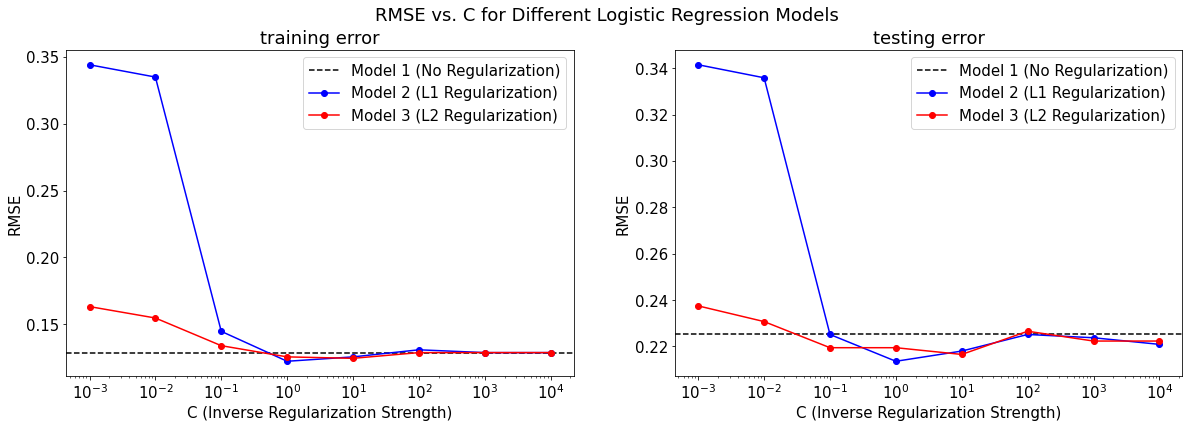

In [59]:
fig, axs = plt.subplots(1, 2, figsize = (20, 6))
colors = ["blue", "red"]
labels = ["Model 2 (L1 Regularization)", "Model 3 (L2 Regularization)"]
titles = ["training error", "testing error"]

# Plot the results
for i in range(2):
    axs[i].axhline(rmse_none[i], ls = "--", c = "black", label = "Model 1 (No Regularization)")
    # training and testing
    for j in range(2):
        # l1 or l2
        axs[i].plot(C_values, rmses[i, j, :], "-o", label = labels[j], c = colors[j])
    axs[i].set_xlabel("C (Inverse Regularization Strength)")
    axs[i].set_ylabel("RMSE")
    axs[i].set_title(titles[i])
    axs[i].set_xscale("log")
    axs[i].legend(loc = "best")
plt.suptitle("RMSE vs. C for Different Logistic Regression Models")
plt.show()

## Full-category classification
Predicting rating class 1-5 rather than binary classification.

Text(0.5, 0.98, 'Category distribution on training and testing dataset')

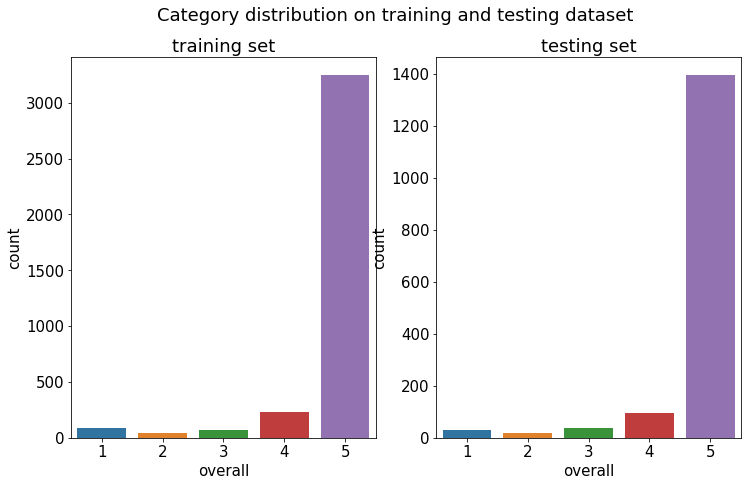

In [54]:
Y_train = train_set["overall"]
Y_test = test_set["overall"]

fig, axes = plt.subplots(1, 2, figsize = (12, 7))
sns.countplot(Y_train, ax = axes[0])
axes[0].set_title("training set")
sns.countplot(Y_test, ax = axes[1])
axes[1].set_title("testing set")
plt.suptitle("Category distribution on training and testing dataset")

### Predicting overall rating by ordinal multinomial regression

training error: RMSE 0.15195904451170592
testing error: RMSE 0.3377401975848282


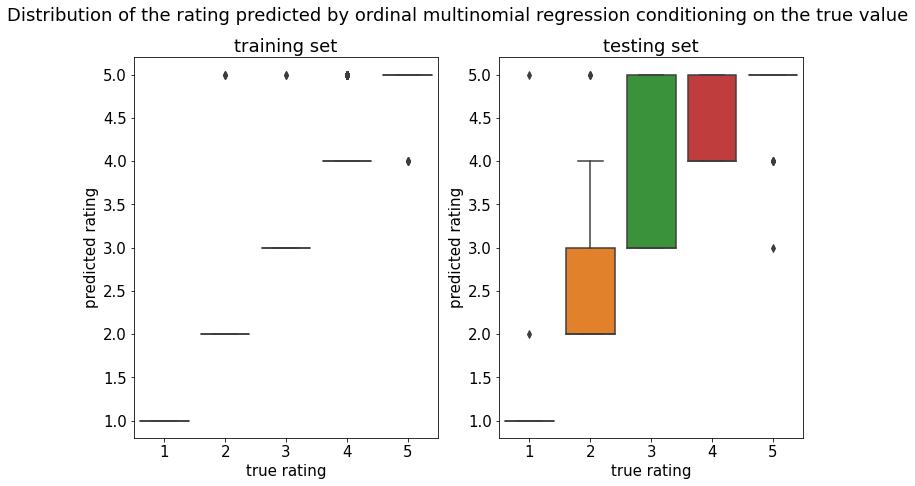

In [55]:
mult = LogisticRegression(multi_class = "multinomial",solver = "lbfgs")

mult.fit(X_train, Y_train)

pred_train = mult.predict(X_train)
pred_test = mult.predict(X_test)
fig, axes = plt.subplots(1, 2, figsize = (12, 7))
for i, (predval, Y) in enumerate(zip(
    [pred_train, pred_test],
    [Y_train, Y_test]
    )):
    temp = pd.DataFrame({
        "true rating": Y,
        "predicted rating": predval
    })
    sns.boxplot(data = temp, x = "true rating", y = "predicted rating", ax = axes[i])
axes[0].set_title("training set")
axes[1].set_title("testing set")
plt.suptitle("Distribution of the rating predicted by ordinal multinomial regression conditioning on the true value")

print(
    "training error: RMSE", np.sqrt(mean_squared_error(pred_train, Y_train))
)

print(
    "testing error: RMSE", np.sqrt(mean_squared_error(pred_test, Y_test))
)

visualize confusion matrix for multi-category classification

In [56]:
def mult_confusion_matrix(X, Y, title, normalize = True):
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        mult, X, Y,
        cmap = plt.cm.Blues,
        normalize = "true" if normalize else None,
    )
    plt.title(title)
    disp.figure_.set_figwidth(8)
    disp.figure_.set_figheight(8)
    plt.show()

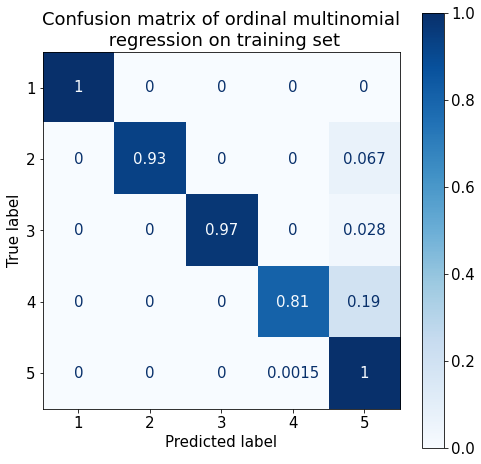

In [57]:
mult_confusion_matrix(X_train, Y_train, "Confusion matrix of ordinal multinomial\n regression on training set")

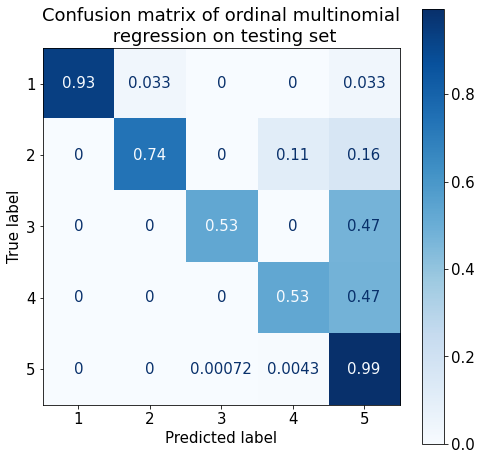

In [58]:
mult_confusion_matrix(X_test, Y_test, "Confusion matrix of ordinal multinomial\n regression on testing set")

### Random forest multi-category classification

training error: RMSE 0.09027712473380922
testing error: RMSE 0.30831320798910367


array([[  85,    0,    0,    0,    0],
       [   0,   42,    0,    0,    3],
       [   0,    0,   71,    0,    0],
       [   0,    0,    0,  232,    3],
       [   0,    0,    0,    0, 3245]])

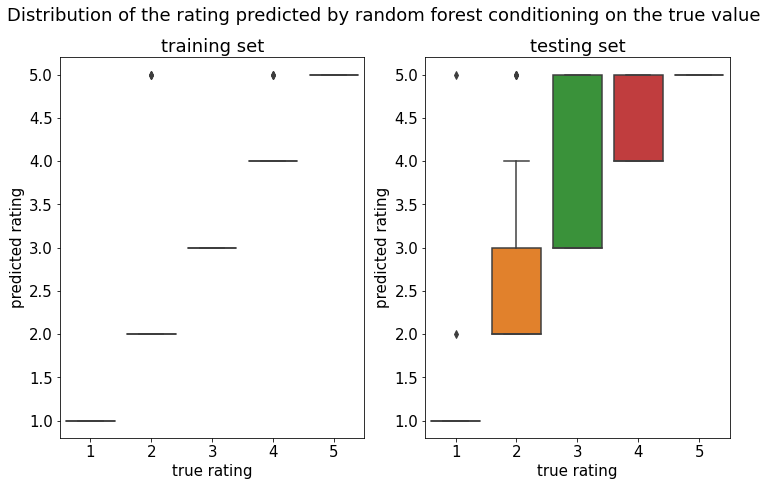

In [60]:
rfclf = RandomForestClassifier(random_state = 42)

rfclf.fit(X_train, Y_train)

pred_train = rfclf.predict(X_train)
pred_test = rfclf.predict(X_test)
fig, axes = plt.subplots(1, 2, figsize = (12, 7))
for i, (predval, Y) in enumerate(zip(
    [pred_train, pred_test],
    [Y_train, Y_test]
    )):
    temp = pd.DataFrame({
        "true rating": Y,
        "predicted rating": predval
    })
    sns.boxplot(data = temp, x = "true rating", y = "predicted rating", ax = axes[i])
axes[0].set_title("training set")
axes[1].set_title("testing set")
plt.suptitle("Distribution of the rating predicted by random forest conditioning on the true value")

print(
    "training error: RMSE", np.sqrt(mean_squared_error(pred_train, Y_train))
)

print(
    "testing error: RMSE", np.sqrt(mean_squared_error(pred_test, Y_test))
)

confusion_matrix(Y_train, pred_train)

# Understanding the hardness of classification
We visualize the dataset in a 2-dimensional subspace to see structral information and understand the hardness of multi-category classification against binary classification

In [61]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state = 50)
X_2D = tsne.fit_transform(X_train)

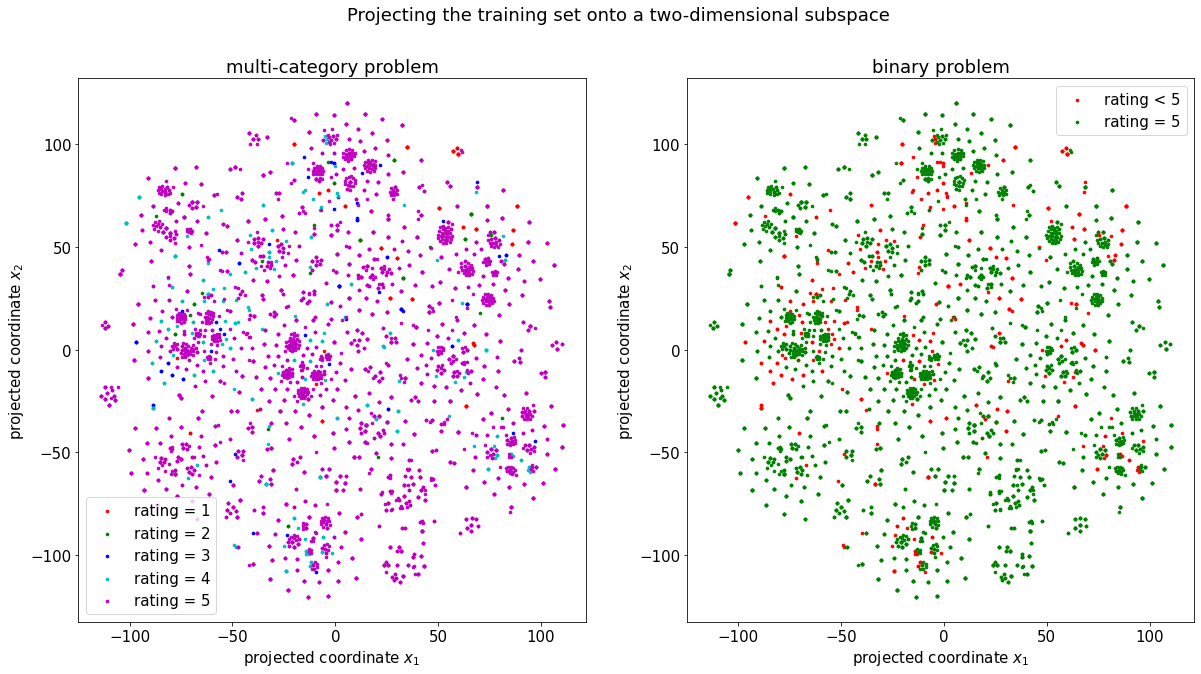

In [62]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10))
colors = ["r", "g", "b", "c", "m"]
for i in range(5):
    axs[0].scatter(X_2D[Y_train == i + 1, 0], X_2D[Y_train == i + 1, 1], c = colors[i], s = 7, label = f"rating = {i + 1}")
axs[1].scatter(X_2D[Y_train != 5, 0], X_2D[Y_train != 5, 1], c = colors[0], s = 7, label = f"rating < 5")
axs[1].scatter(X_2D[Y_train == 5, 0], X_2D[Y_train == 5, 1], c = colors[1], s = 7, label = f"rating = 5")
for i in range(2):
    axs[i].set_xlabel(r"projected coordinate $x_1$")
    axs[i].set_ylabel(r"projected coordinate $x_2$")
    axs[i].legend(loc = "best")
axs[0].set_title("multi-category problem")
axs[1].set_title("binary problem")
plt.suptitle("Projecting the training set onto a two-dimensional subspace")
plt.show()

5-star data exhibits some structure in a projected low-dimensional space while the structure for other star-based categories is weak. The spreading behaviour of other star-based categories suggests that aggregating them together as a single category may reduce the hardness of the classification problem. This is also justified from previous experiments. Furthermore, the lack in the structure also suggest the use of nonlinear classifiers to learn more complex relation in dataset.

**Using logistic regression (generalized linear model, GLM)**

- binary classification RMSE 0.13 (training), 0.22 (testing)

- multi-category classification RMSE 0.15 (training), 0.34 (testing)

**Using random forest (nonlinear classifier)**

- binary classification RMSE 0.04 (training()), 0.17 (testing)

- multi-category classification RMSE 0.09 (training), 0.31 (testing)

# Clustering to show the similarity information among reviews
We employ a k-means clustering method to cluster the vectorized review summary. The cluster assignment indicates that most reviews are in the first class. Furthermore, the table also shows that different clusters have very similar structure. This suggests that there is fruitful structural information in the data that can be used for dimensionality reduction and building recommendation system.

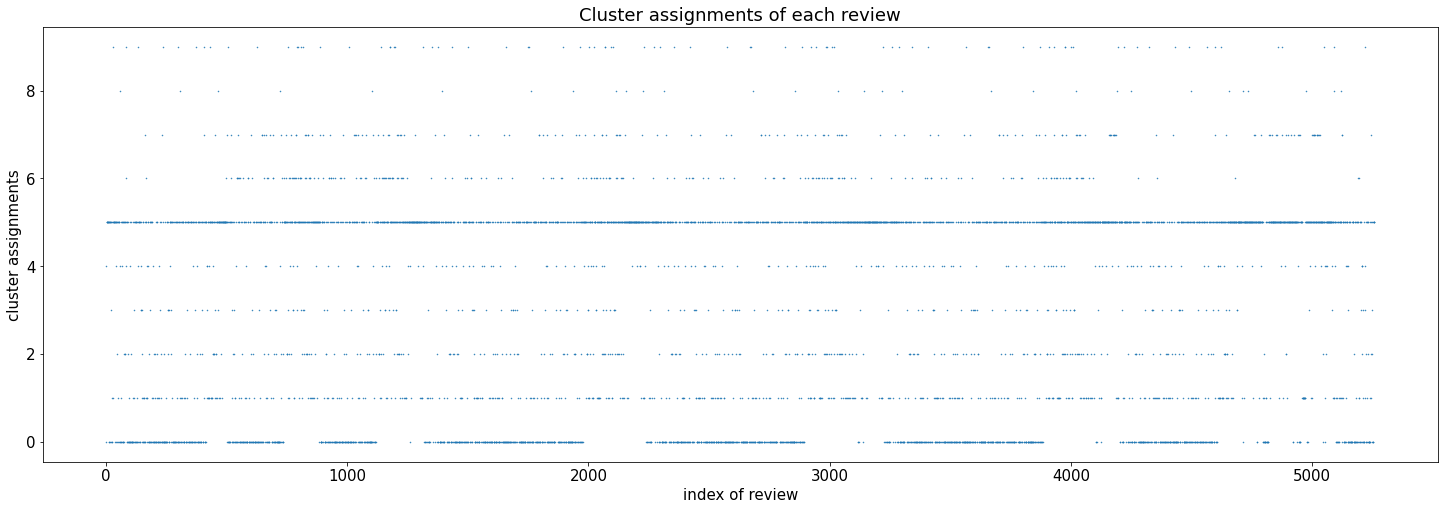

In [63]:

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 10, init = "k-means++")
assignments = kmeans.fit_predict(vec_summary)
plt.figure(figsize = (25, 8))
plt.plot(assignments, ".", ms = 1)
plt.xlabel("index of review")
plt.ylabel("cluster assignments")
plt.title("Cluster assignments of each review")
plt.show()



In [64]:
print("Top words in each cluster")
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
top_words = []
terms = vectorizer_summary.get_feature_names_out()
for i in range(len(centroids)):
    top_words.append(terms[centroids[i, :10]])
pd.DataFrame(
    top_words, index = ["cluster {:d}".format(i) for i in range(len(centroids))]
)

Top words in each cluster


,0,1,2,3,4,5,6,7,8,9
cluster 0,stars,great,wash,wonderful,like,lovely,smells,amazing,perfect,buy
cluster 1,great,product,excellent,smells,gift,soap,shampoo,works,price,fragrance
cluster 2,love,product,stuff,smell,really,kerastase,wish,makeup,thank,labcoat
cluster 3,best,product,stuff,used,shampoo,scent,conditioner,hair,pantene,alien
cluster 4,good,stuff,product,deal,smells,hair,feel,smell,mixed,wonderfully
cluster 5,hair,shampoo,nice,product,like,favorite,really,wonderful,soap,love
cluster 6,body,wash,shower,gel,great,love,favorite,smells,spring,cream
cluster 7,scent,favorite,fresh,clean,beautiful,wonderful,love,great,lovely,light
cluster 8,perfect,guests,scent,sock,promo,strong,burn,size,kit,great
cluster 9,awesome,product,frizzy,bought,selenium,hair,doubt,quality,products,stuff


# Dimensionality reduction and model compression
#### This section is very time consuming. Running cells for data generation costs either 10 mins or 70 mins. If it is not necessary, do not rerun this section.

In [65]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

The model is built by stacking a PCA, for dimensionality reduction of feature space, and a random forest classifier. The hyperparameters is set to the dimension of the hidden feature space, which is the space of features after applying PCA. This section aims to show that by compressing the feature space, the performance of the model can still be maintained but the model complexity in the most expensive classification part is significantly reduced. We will study this by cross validation.

In [66]:
def build_model(hidden_feat_dimension):
    steps = [
        ("PCA", PCA(
            copy = True, n_components = hidden_feat_dimension, random_state = 42
        )),
        ("RF", RandomForestClassifier(random_state = 42))
    ]
    return Pipeline(steps = steps)

def evaluate_model(model, X, Y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    return cross_val_score(model, X, Y, scoring = "accuracy", cv = cv)

A more detailed search in small space dimension

In [67]:
hidden_feat_dims = range(1, 21)
cv_scores = []
for hidden_dim in hidden_feat_dims:
    temp = pd.DataFrame({"cv score": evaluate_model(build_model(hidden_dim), X_train, Y_train)})
    temp["hidden feature dimension"] = hidden_dim
    cv_scores.append(temp)
cv_scores = pd.concat(cv_scores, ignore_index = True)
cv_scores.head()

,cv score,hidden feature dimension
0,0.734417,1
1,0.763587,1
2,0.782609,1
3,0.722826,1
4,0.766304,1


A more coarse grained search in big spce dimension

In [68]:
hidden_feat_dims_large = range(100, 1001, 50)
cv_scores_large = []
for hidden_dim in hidden_feat_dims_large:
    temp = pd.DataFrame({"cv score": evaluate_model(build_model(hidden_dim), X_train, Y_train)})
    temp["hidden feature dimension"] = hidden_dim
    cv_scores_large.append(temp)
cv_scores_large = pd.concat(cv_scores_large, ignore_index = True)
cv_scores_large.head()

,cv score,hidden feature dimension
0,0.943089,100
1,0.948370,100
2,0.956522,100
3,0.953804,100
4,0.953804,100


plot the accuracy curve generated by cross validation

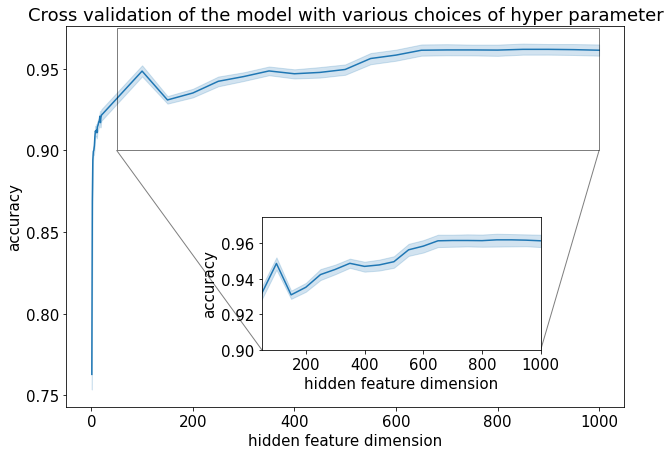

In [69]:
concat_data = pd.concat([cv_scores, cv_scores_large], ignore_index = True).rename(columns = {"cv score": "accuracy"})

fig = plt.figure(figsize = (10,7))
ax = plt.axes()
sns.lineplot(data = concat_data, x = "hidden feature dimension", y = "accuracy", ax = ax)

x1 = 50
x2 = 1000
y1 = 0.9
y2 = 0.975

axins = ax.inset_axes([0.35, 0.15, 0.5, 0.35], xlim=(x1, x2), ylim=(y1, y2))
sns.lineplot(data = concat_data, x = "hidden feature dimension", y = "accuracy", ax = axins)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.title("Cross validation of the model with various choices of hyper parameter")
plt.show()


The cross validation suggests that before passing the data to a classifier, e.g., random forest, reducing the feature dimension by using dimensionality reduction methods like PCA can preserve a relatively high model performance. However, because the dimensionality has been reduced, the further training of complex classifier can be faster.

# Building a recommendation system by using collaborative filtering

The high level idea is to learn the correlation between different products by investigating the historical engagement between reviewers and products. A SVD is performed to derive a 10-dimensional hidden feature vector of each reviewer and each product. Then, a inner product, a.k.a. cosine similarity, is used to compute the similarity score between products. 

In [70]:
from sklearn.decomposition import TruncatedSVD
hidden_state_dimension = 10
SVD = TruncatedSVD(n_components = hidden_state_dimension)

build the reviewer-product interaction matrix and derive hidden feature vector representation for each product by performing SVD

In [71]:
interaction_matrix = df.pivot_table(
    values = "overall",
    index = "asin",
    columns = "reviewerID",
    fill_value = 0
)
print(interaction_matrix.shape)
interaction_matrix.head()

(85, 989)


reviewerID,A105A034ZG9EHO,A10JB7YPWZGRF4,A10M2MLE2R0L6K,A10P0NAKKRYKTZ,A10ZJZNO4DAVB,A1118RD3AJD5KH,A115LE3GBAO8I6,A11AZPF8R6A1F8,A11L1TI883AOSV,A11QGZ39A7ZF0X,...,AYNTULRNAIPNY,AYORX1AK30JMB,AYY463Q7V3LTU,AZ4T3DDT8L9EQ,AZ520NWW40I9B,AZCOSCQG73JZ1,AZD3ON9ZMEGL6,AZFYUPGEE6KLW,AZJMUP77WBQZQ,AZRD4IZU6TBFV
asin,,,,,,,,,,,,,,,,,,,,,
B0000530HU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00006L9LC,0,0,0,0,5,5,0,5,5,0,...,0,0,5,5,5,5,0,5,5,0
B00021DJ32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B0002JHI1I,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B0006O10P4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
product_hidden_feats = SVD.fit_transform(interaction_matrix)
product_hidden_feats.shape

(85, 10)

In [73]:
product_correlation_matrix = np.corrcoef(product_hidden_feats)
product_correlation_matrix .shape

(85, 85)

## Recommend products that are similar to the first product
We manually search these asin in Amazon to confirm that the recommendation system makes sense.

In [74]:
chosen_index = 0
chosen_product = interaction_matrix.index[chosen_index]
print(chosen_product)
n_similar_products = 5
indices_by_correlation_scores = product_correlation_matrix[chosen_index, :].flatten().argsort().tolist()
indices_by_correlation_scores.remove(chosen_index)

B0000530HU


In [75]:
similar_products_indices = indices_by_correlation_scores[-1:-n_similar_products - 1:-1]
correlation_scores = product_correlation_matrix[chosen_index, similar_products_indices]
similar_products_ID = interaction_matrix.index[similar_products_indices]
similar_products = pd.DataFrame({"similar_product_ID": similar_products_ID, "correlation_score": correlation_scores})
similar_products

,similar_product_ID,correlation_score
0,B000FTYALG,1.000000
1,B001QY8QXM,0.998301
2,B0013NB7DW,0.943268
3,B019809F9Y,0.941455
4,B001E5PLCM,0.862455


In [76]:
print("The chosen product is 'Aqua Velva After Shave, Classic Ice Blue, Soothes, Cools, and Refreshes Skin, 7 Ounce'.")
similar_products["description"] = [
    "Aqua Velva After Shave, Classic Ice Blue, Soothes, Cools, and Refreshes Skin, 3.5 Ounce", # B000FTYALG
    "Astra Platinum Double Edge Safety Razor Blades ,100 Count (Pack of 1)", # B001QY8QXM
    "Williams Lectric Shave, Electric Rotary Razor Pre-Shave For men, 7 Ounce", # B0013NB7DW
    "Williams Lectric Shave", # B019809F9Y
    "Clubman Lustray Blue Spice After Shave, 1 Gallon", # B001E5PLCM
]
pd.set_option('display.max_colwidth', None)
similar_products

The chosen product is 'Aqua Velva After Shave, Classic Ice Blue, Soothes, Cools, and Refreshes Skin, 7 Ounce'.


,similar_product_ID,correlation_score,description
0,B000FTYALG,1.000000,"Aqua Velva After Shave, Classic Ice Blue, Soothes, Cools, and Refreshes Skin, 3.5 Ounce"
1,B001QY8QXM,0.998301,"Astra Platinum Double Edge Safety Razor Blades ,100 Count (Pack of 1)"
2,B0013NB7DW,0.943268,"Williams Lectric Shave, Electric Rotary Razor Pre-Shave For men, 7 Ounce"
3,B019809F9Y,0.941455,Williams Lectric Shave
4,B001E5PLCM,0.862455,"Clubman Lustray Blue Spice After Shave, 1 Gallon"
